In [1]:
import torch # used to create tensors to store all of the numerical values including the raw data and values for weights and biases
import torch.nn as nn # used to make weights and biases part of the neural network
import torch.nn.functional as F # gives us the activation functions 
from torch.optim import SGD # stochastic gradient descent to fit neural network to the data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# for each new neural network we create a new class
class BasicNN(nn.Module): 
    def __init__(self):
        super().__init__() #initialising the parent class
        #initialising weights and biases of the neural network
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad = False) # first weight 00 is initialised as 1.7 value and we wont be optimising it using gradient descent 
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad = False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad = False)
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad = False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad = False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad = False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad = False)

    def forward(self, input): # does a forward pass through the neural network to calclate and return the output value 
        # passing the input through the activation function in top layer
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        # transforming the output of the relu function in top layer
        scaled_top_relu_output = top_relu_output * self.w01

        # passing the input through the activation function in bottom layer
        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        # transforming the output of the relu function in bottom layer
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

In [4]:
# we are using the examples of medicine does which do not work at low and high doses, but work at medium doses
input_doses = torch.linspace(start = 0, end = 1, steps = 11) # creating a tensor with a sequence of 11 values between and including 0 and 1
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [5]:
model = BasicNN()
output_values = model(input_doses)
output_values

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0100, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

<Axes: xlabel='None', ylabel='None'>

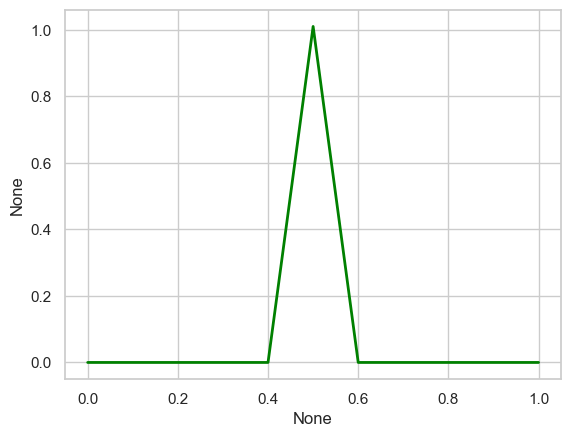

In [6]:
# plotting the predictions
sns.set(style = 'whitegrid')
sns.lineplot(x = input_doses, y = output_values, color = 'green', linewidth = 2)

In [7]:
# now we create another neural network where we dont not the value of the final_bias
# using pytorch to optimize the value of final_bias using backpropagation
# we randomly initialise final_bias to 0.0

<Axes: xlabel='None', ylabel='None'>

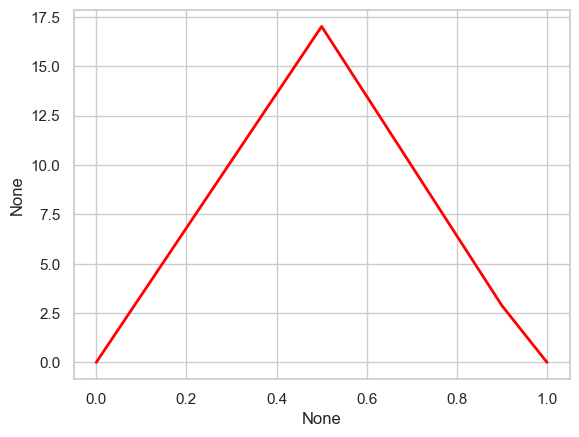

In [8]:
class BasicNN_train(nn.Module):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad = False) # first weight 00 is initialised as 1.7 value and we wont be optimising it using gradient descent 
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad = False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad = False)
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad = False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad = False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad = False)

        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad = True)

    def forward(self, input): # does a forward pass through the neural network to calclate and return the output value 
        # passing the input through the activation function in top layer
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        # transforming the output of the relu function in top layer
        scaled_top_relu_output = top_relu_output * self.w01

        # passing the input through the activation function in bottom layer
        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        # transforming the output of the relu function in bottom layer
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

# we can see that the new model with non-optimised final_bias does not fit the input data well by plotting a graph

model = BasicNN_train()
input_doses = torch.linspace(start=0, end=1, steps=11)
output_doses = model(input_doses)

# plotting graph
sns.set(style = 'whitegrid')
sns.lineplot(x = input_doses, y = output_doses.detach(), color = 'red', linewidth = 2)
# because final_bias now has a gradient, we can detach() on the output values to create a new tensor that only has the output values
# basically seaborn does not know what to do with the gradient, so we strip it off using detach()

In [9]:
# training the neural network to optimise final_bias
inputs = torch.tensor([0., 0.5, 1.])
labels = torch.tensor([0., 1., 0.])

#training the model
optimizer = SGD(model.parameters(), lr=0.1) # we pass model parameters to SGD, which will optimise every parameter we set requires_grad to True
print(f"Final Bias before optimization: {model.final_bias.data}\n")

# each time our training code sees the full training data is called an epoch
for epoch in range(100):
    total_loss = 0
    for iteration in range(len(inputs)):
        input_i = inputs[iteration]
        label_i = labels[iteration]
        output_i = model(input_i)

        loss = (output_i - label_i) **2
        loss.backward() # used to calculate the derivative of the loss function wrt parameter/s we want to optimize. it also keeps track of derivative of loss for each sample and adds it 
        total_loss +=float(loss)

    if total_loss < 0.0001:
        print(f"num steps: {epoch}")
        break

    optimizer.step()
    # once the model has taken a step towards optimised final_bias, 
    # we need to zero out the derivatives that we're storing for that epoch
    # otherwise we will keep on adding derivatives of losses for each epoch to its next epoch 
    optimizer.zero_grad() 
    print(f"step: {epoch} Final Bias: {model.final_bias.data}\n")

print(f"Final Bias after Optimization: {model.final_bias.data}")

Final Bias before optimization: 0.0

step: 0 Final Bias: -3.202000141143799

step: 1 Final Bias: -5.7636003494262695

step: 2 Final Bias: -7.812880516052246

step: 3 Final Bias: -9.45230484008789

step: 4 Final Bias: -10.763843536376953

step: 5 Final Bias: -11.813075065612793

step: 6 Final Bias: -12.652460098266602

step: 7 Final Bias: -13.323967933654785

step: 8 Final Bias: -13.861174583435059

step: 9 Final Bias: -14.290939331054688

step: 10 Final Bias: -14.634751319885254

step: 11 Final Bias: -14.909801483154297

step: 12 Final Bias: -15.129840850830078

step: 13 Final Bias: -15.305872917175293

step: 14 Final Bias: -15.446698188781738

step: 15 Final Bias: -15.559358596801758

step: 16 Final Bias: -15.649486541748047

step: 17 Final Bias: -15.721589088439941

step: 18 Final Bias: -15.779271125793457

step: 19 Final Bias: -15.825416564941406

step: 20 Final Bias: -15.862333297729492

step: 21 Final Bias: -15.891866683959961

step: 22 Final Bias: -15.91549301147461

step: 23 Fin

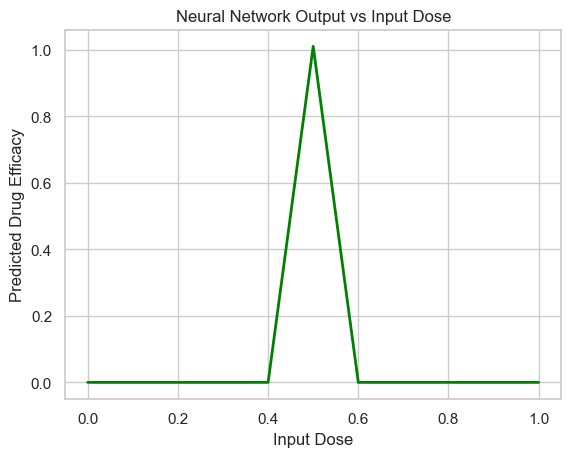

In [11]:
# testing the new model
output = model(input_doses)
# plotting the predictions
sns.set(style = 'whitegrid')
sns.lineplot(x = input_doses, y = output_values, color = 'green', linewidth = 2)

plt.xlabel("Input Dose")
plt.ylabel("Predicted Drug Efficacy")

plt.title("Neural Network Output vs Input Dose")
plt.show()